<p><b>Devcon #18 100 % quantique - 23 février 2023 - ESGI Paris</b></p>
<h1>AQASM/myQLM, la solution quantique d'Atos</h1>

<h1>Intrication : état de Bell</h1>

<h2>Installation</h2>

In [15]:
# https://myqlm.github.io/myqlm_specific/install.html
# Installer Python 3
# pip install myqlm # Installer myqlm
# pip install myqlm-interop # Installer le package d'interop
# python3 -m qat.magics.install # Pour avoir %qatdisplay dans Jupyter

<h2>Création du circuit quantique relatif à un état de Bell et génération de l'image</h2>

In [16]:
from qat.lang.AQASM import Program, H, CNOT

qprog = Program()

nbqbits = 2
qbits = qprog.qalloc(nbqbits)

# Porte de Hadamard
qprog.apply(H, qbits[0])

# Porte CNOT
qprog.apply(CNOT, qbits[0], qbits[1])

circuit = qprog.to_circ()

# Affichage du circuit
# display(circuit) # Ne fonctionne pas sous Jupyter
%qatdisplay circuit --svg

<h2>Simulation avec n=10</h2>

état quantique |00> -> probabilité : 0.4
état quantique |11> -> probabilité : 0.6
{'|00>': 0.4, '|01>': 0.0, '|10>': 0.0, '|11>': 0.6}


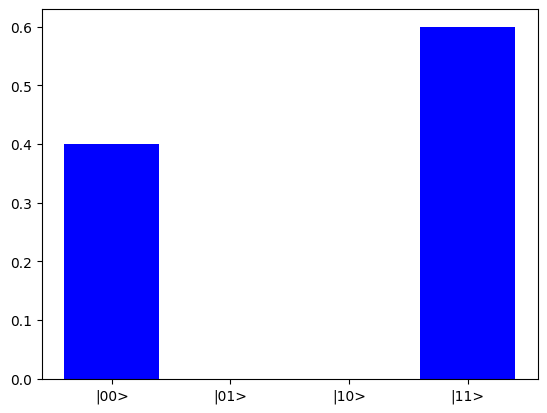

In [17]:
from qat.qpus import PyLinalg
import matplotlib.pyplot as plt

pylinalgqpu = PyLinalg()
job = circuit.to_job(nbshots=10)

result = pylinalgqpu.submit(job)

dictionnaire = {}
dictionnaire['|00>'] = float(0)
dictionnaire['|01>'] = float(0)
dictionnaire['|10>'] = float(0)
dictionnaire['|11>'] = float(0)

for sample in result:
    dictionnaire[str(sample.state)] = float(sample.probability)
    print("état quantique %s -> probabilité : %s" % (sample.state, sample.probability))

print(dictionnaire)
plt.bar(dictionnaire.keys(), dictionnaire.values(), color='b')
plt.show()

<h2>Simulation avec n=1000</h2>

état quantique |11> -> probabilité : 0.519
état quantique |00> -> probabilité : 0.481
{'|00>': 0.481, '|01>': 0.0, '|10>': 0.0, '|11>': 0.519}


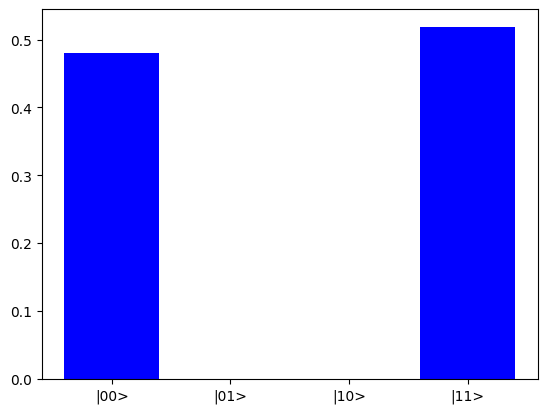

In [18]:
job = circuit.to_job(nbshots=1000)

result = pylinalgqpu.submit(job)

dictionnaire['|00>'] = float(0)
dictionnaire['|01>'] = float(0)
dictionnaire['|10>'] = float(0)
dictionnaire['|11>'] = float(0)

for sample in result:
    dictionnaire[str(sample.state)] = float(sample.probability)
    print("état quantique %s -> probabilité : %s" % (sample.state, sample.probability))

print(dictionnaire)
plt.bar(dictionnaire.keys(), dictionnaire.values(), color='b')
plt.show()

<h2>Interop Qiskit</h2>

ibmqfactory.load_account:WARNING:2023-02-19 14:35:51,667: Credentials are already in use. The existing account in the session will be replaced.


état quantique |00> -> probabilité : 0.52
état quantique |11> -> probabilité : 0.48
{'|00>': 0.52, '|01>': 0.0, '|10>': 0.0, '|11>': 0.48}


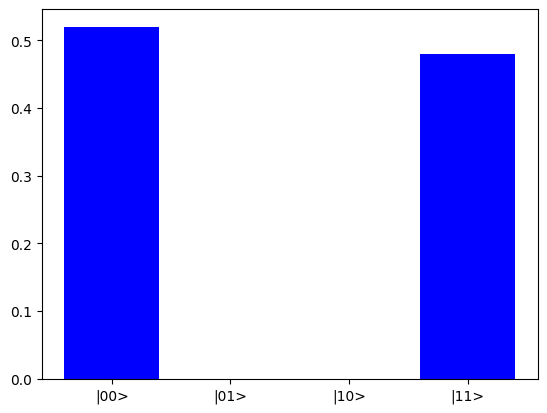

In [19]:
# https://quantum-computing.ibm.com/
from qat.interop.qiskit import qlm_to_qiskit
from qat.interop.qiskit import BackendToQPU

job = circuit.to_job(nbshots=1000)
qiskit_circuit = qlm_to_qiskit(circuit)    
MY_IBM_TOKEN = "**************************"
qpu = BackendToQPU(token=MY_IBM_TOKEN, ibmq_backend="ibmq_qasm_simulator")

dictionnaire['|00>'] = float(0)
dictionnaire['|01>'] = float(0)
dictionnaire['|10>'] = float(0)
dictionnaire['|11>'] = float(0)

result = qpu.submit(job)

for sample in result:
    dictionnaire[str(sample.state)] = float(sample.probability)
    print("état quantique %s -> probabilité : %s" % (sample.state, sample.probability))

print(dictionnaire)
plt.bar(dictionnaire.keys(), dictionnaire.values(), color='b')
plt.show()

<h2>Fichiers .aqasm et .circ</h2>

In [20]:
qprog.export("Devcon18.aqasm")
qprog.export("Devcon18.circ")

<h1>Téléportation quantique</h1>

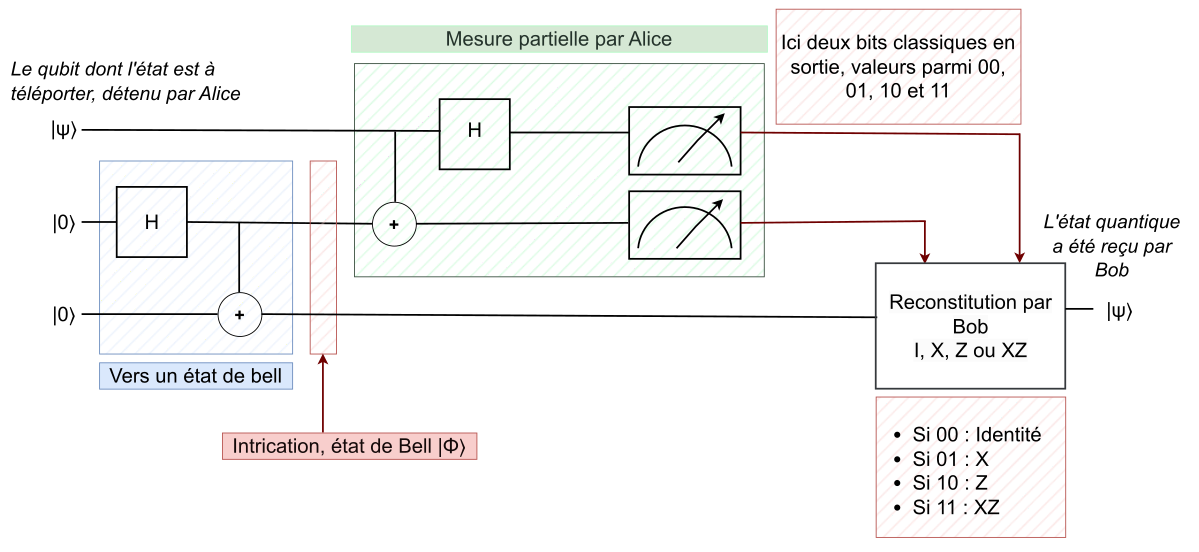
<small>Benoît Prieur CC0 via Wikimedia Commons</small>

In [21]:
from qat.lang.AQASM import *

pr = Program()
qbit_teleporter_alice = pr.qalloc()
qbit_intrication = pr.qalloc() 
qbit_bob = pr.qalloc()

bit_classique_intrication = pr.calloc()
bit_classique_teleportation = pr.calloc()

pr.apply(H, qbit_intrication)
pr.apply(CNOT, qbit_intrication, qbit_bob)

In [22]:
from random import random
from math import pi

pr.apply(RX(random() * 2 * pi), qbit_teleporter_alice)
pr.apply(RY(random() * 2 * pi), qbit_teleporter_alice)
pr.apply(RZ(random() * 2 * pi), qbit_teleporter_alice)

circ = pr.to_circ()
%qatdisplay circ --svg

In [23]:
import copy
pr2 = copy.deepcopy(pr)

In [24]:
from qat.qpus import PyLinalg

qpu = PyLinalg()

res = qpu.submit(circ.to_job())
for sample in res:
    print("état quantique %s -> probabilité : %s" % (sample.state, sample.probability))

état quantique |0>|0>|0> -> probabilité : 0.24803837403245213
état quantique |0>|1>|1> -> probabilité : 0.24803837403245213
état quantique |1>|0>|0> -> probabilité : 0.25196162596754773
état quantique |1>|1>|1> -> probabilité : 0.25196162596754773


In [25]:
res = qpu.submit(circ.to_job(qubits=[qbit_teleporter_alice]))
for sample in res:
    print("état quantique %s -> probabilité : %s" % (sample.state, sample.probability))

état quantique |0> -> probabilité : 0.4960767480649042
état quantique |1> -> probabilité : 0.5039232519350955


In [26]:
pr2.apply(CNOT, qbit_teleporter_alice, qbit_intrication)
pr2.apply(H, qbit_teleporter_alice)
pr2.measure(qbit_teleporter_alice, bit_classique_teleportation)
pr2.measure(qbit_intrication, bit_classique_intrication)

pr2.cc_apply(bit_classique_intrication, X, qbit_bob)
pr2.cc_apply(bit_classique_teleportation, Z, qbit_bob)

circ2 = pr2.to_circ()
%qatdisplay circ2 --svg

In [27]:
res2 = qpu.submit(circ2.to_job(qubits=[qbit_bob]))

for sample in res2:
    print("état quantique %s -> probabilité : %s" % (sample.state, sample.probability))

état quantique |0> -> probabilité : 0.4960767480649043
état quantique |1> -> probabilité : 0.5039232519350956
